In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Importing the dataset 
df = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
df_copy = df.copy()

In [ ]:
#EDA
# Lets try looking at the head
df.head(5)

We observe that there 5 columns CustomerID 	Gender 	Age 	Annual Income (k$) 	Spending Score (1-100)

In [ ]:
df.describe()

Age - lies between 18 and 70, all values seem to be legible
<br>
Annual income - Lies between 15k to 137k $
<br>
Spending score - Lies between 1 and 99, which also seems legible

In [ ]:
#plotting Age parameters
ageCountPlot = sns.countplot(x="Gender", data=df, palette="Set3")
#calculating male female observations
print(df['Gender'].value_counts())

We can see that the sampling consists of more females customers, as compared to male customers.

In [ ]:
#plotting Annual Income parameters
annualIncomePlot = sns.displot(df, x="Annual Income (k$)",bins = 20)
sns.catplot(x="Gender", y="Annual Income (k$)", kind="box", data=df)

We observe that 
<li> the data is not distributed as per any know distribution, the mean annual income lies in the 60+=Δ </li>
<li> Male customers have a higher mean annual income with less variance </li> 

In [ ]:
#plotting Spending Score parameters
scorePlot = sns.displot(df, x="Spending Score (1-100)",bins = 30)
sns.catplot(x="Gender", y="Spending Score (1-100)", kind="box", data=df)

In [ ]:
#plotting Age Income parameters
AgePlot = sns.displot(df, x="Age",bins = 20)
sns.catplot(x="Gender", y="Age", kind="box", data=df)

In [ ]:
#plotting Age V/S gender distributions
sns.displot(df, x="Age", y="Gender",cbar=True)
sns.jointplot(data=df, x="Age", y="Gender")

We observe that number of customer's sampled which are women in the age between 30 and 40 is a surprisingly large as compared to other segments

In [ ]:
#Lets try to analyze relation between income and spending score
sns.displot(df, x="Annual Income (k$)", y="Spending Score (1-100)",cbar=True)
sns.jointplot(data=df, x="Annual Income (k$)", y="Spending Score (1-100)",hue = "Gender")

# We can make some decent insights from this
* The customers can be divided into 5 segments on the basis of spending score / annual income

    1. Low spending high income ( Region 1 )  
    2. Low Spending low income (Region 2 ) 
    3. High spending low income ( Region 3 )
    4. High spending high income (Region 4 ) 
    5.  Mean spending and income (Region 5) 
    
* The maximum customers sampled lies in the 5th category 

    
   

In [ ]:
#Lets try to analyze relation between Age and Income
sns.displot(df, x="Annual Income (k$)", y="Age",cbar=True)
sns.jointplot(data=df, x="Annual Income (k$)", y="Age", hue = "Gender")

There are no significant insights, the sampling seems to more or less uniform

In [ ]:
#Lets try to analyze relation between Age and Spending score
sns.displot(df, x="Spending Score (1-100)", y="Age",cbar=True)
sns.jointplot(data=df, x="Spending Score (1-100)", y="Age")

#Analysing spending scores for customers over 40 years
sns.displot(df[df['Age']>=40],x = "Spending Score (1-100)")
sns.displot(df[df['Age']<40],x = "Spending Score (1-100)")

1. Beyond the age of 40, there are very few customers with a spending >= 60, One way to explain thish could be the fact that as one grows older, he tends to save for his children, tries to reduce his spendings.

In [ ]:
#Correlation matrix 
sns.heatmap(df.drop(['CustomerID'],axis = 1).corr(),annot = True,cmap = "coolwarm")

Final words before moving towards clustering 
<pre> 1. The clusters seems most apparent when taking spending score with income, the clusters formed here seems to be independent of the gender
2. One thing which was not apparent from previous graphs, but is from the correlation matrix is that Spending score and age are negatively correlated, with a significant value of correlation</pre>

In [ ]:
#normalizing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Annual Income (k$)'] = scaler.fit_transform(df['Annual Income (k$)'].values.reshape(-1,1))
df['Spending Score (1-100)'] = scaler.fit_transform(df['Spending Score (1-100)'].values.reshape(-1,1))
df['Age'] = scaler.fit_transform(df['Age'].values.reshape(-1,1))

In [ ]:
def closest(clusterPoints,numberClusters,currPoint):
    dist = np.inf;
    belongs_to =0 
    idx =0
    for vec in clusterPoints:
        dist_from_vec = np.sum((np.array(vec)-np.array(currPoint))**2)
        if(dist_from_vec < dist):
            dist = dist_from_vec
            belongs_to = idx
        idx+=1
    return int(belongs_to)


def cluster(numberClusters,params,iterations,dataset):
    totalPoints = dataset.shape[0]
    minVariance = np.inf
    finClasses = []
    while(iterations!=0):
        iterations-=1;
        IterationVariance = 0
        clusterPoints = np.random.randn(numberClusters,len(params))
        belongsTo = np.zeros(dataset.shape[0],dtype = 'uint8')
        changed = True
        while(changed):
            changed = False

            for i in range(totalPoints):
                
                point = dataset.iloc[i,params]

                nearestClusterPoint = closest(clusterPoints,numberClusters,point)
            
                if(nearestClusterPoint!=belongsTo[i]):
                    changed = True
                    belongsTo[i] = nearestClusterPoint;
                    
            #Re locating cluster points
            tempClusterPoints = np.zeros((numberClusters,len(params)),dtype = "float")
            perClusterCount = np.zeros(numberClusters)
            
            for i in range(totalPoints):
                idx = belongsTo[i]
                point = dataset.iloc[i,params]
                perClusterCount[idx]+=1
                tempClusterPoints[idx] = tempClusterPoints[idx] + np.array(point)
                
            for i in range(numberClusters):
                if(perClusterCount[i] == 0):
                    continue
                tempClusterPoints[i]/=perClusterCount[i]
            
            clusterPoints = tempClusterPoints
        
        for i in range(totalPoints):
            point = dataset.iloc[i,params]
            IterationVariance += np.sum((np.array(point) - np.array(clusterPoints[belongsTo[i]]))**2)
    
        if(IterationVariance < minVariance):
            finClasses = belongsTo
            minVariance = min(minVariance,IterationVariance)
    return (belongsTo,minVariance)


In [ ]:
variances = []
clusterFormed = [] 
for i in range(1,10):
    belongsTo,minVariance = cluster(i,[2,3,4],10,df)
    variances.append(minVariance)
    clusterFormed.append(belongsTo)

In [ ]:
plt.plot(variances)

In [ ]:
variances[4]

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()
fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')

zdata = df['Spending Score (1-100)']
xdata = df['Age']
ydata = df['Annual Income (k$)']
ax.scatter3D(xdata, ydata, zdata, c=clusterFormed[4])
plt.show()

In [ ]:
df_copy['clusters'] = clusterFormed[4]
df_copy.drop(['CustomerID'],axis = 1).groupby(['clusters']).agg([np.mean])

Conclusion - customers can be segmented into 5 groups

mean age - 38.850000 
mean annual income - 60.560000 
mean spending score - 50.200000

1. (middle aged, upperclass, very sensitive towards their spending) Highly concerned individuals about their spending, earn more than the mean income but spending score is the lowest out of all the other clusters
2. (middle aged, middle class) 
3. (the slightly older semgent in young individuals, upperclass) Earning significantly more than the mean income and spending the most out of the 5 clusters.
4. ( the young population ) Low annual income in comparison to high spending score 
5. (senior citizens) 

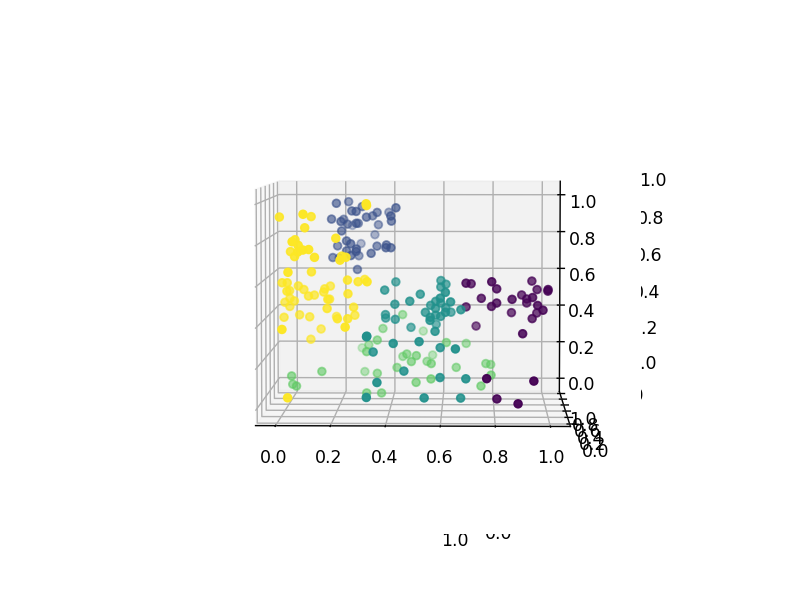

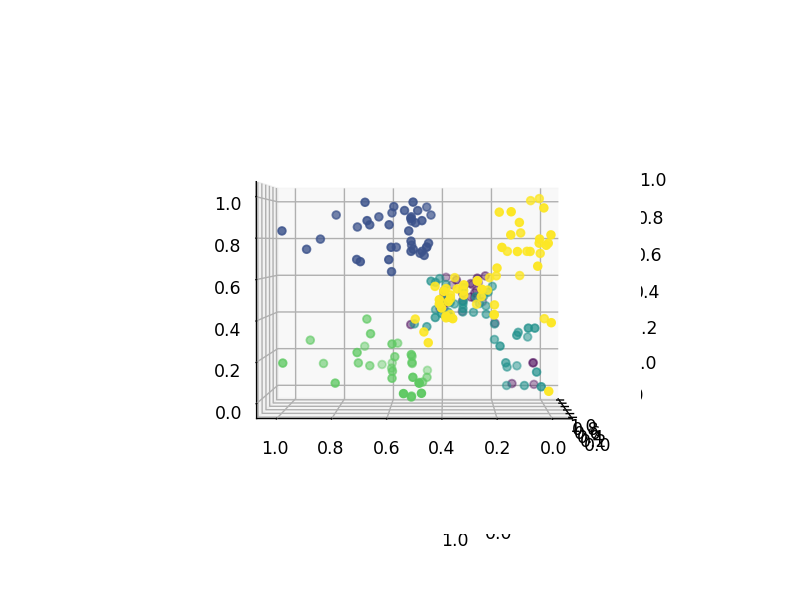


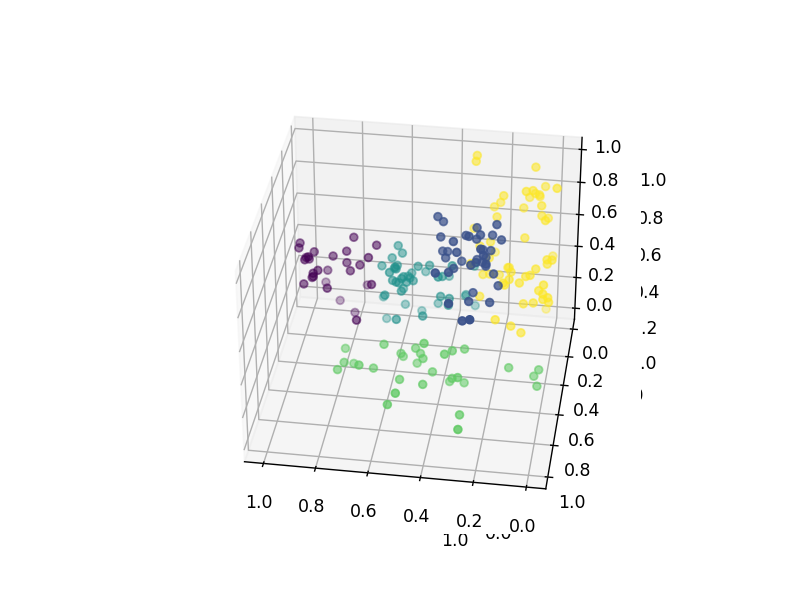